#Import Modules



In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


#Mount Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


#Import train400 Dataset

In [ ]:
images = []
for i in range(9):
  image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/train400/00{}.png".format(i+1))
  input_arr = tf.keras.preprocessing.image.img_to_array(image)
  img = np.divide(input_arr, 255.0)
  images.append(img)

for i in range(10, 99):
  image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/train400/0{}.png".format(i))
  input_arr = tf.keras.preprocessing.image.img_to_array(image)
  img = np.divide(input_arr, 255.0)
  images.append(img)

for i in range(100, 400):
  image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/train400/{}.png".format(i))
  input_arr = tf.keras.preprocessing.image.img_to_array(image)
  img = np.divide(input_arr, 255.0)
  images.append(img)

In [ ]:
images = np.array(images)
print(images.shape)

(398, 180, 180, 3)


#ADD NOISE TO IMAGE

In [ ]:
tf.convert_to_tensor(img, dtype=None, dtype_hint=None, name=None)

import numpy as np
import os
import cv2
def noisy(image):
    row,col,ch= image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy




In [ ]:
image_noisy = []
for img in images:
  image_noisy.append(noisy(img))


<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(398, 180, 180, 3) (398, 180, 180, 3)


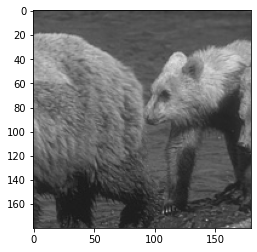

In [ ]:
image_noisy = np.array(image_noisy)
image_noisy.shape
plt.imshow(images[0].reshape(180,180,3))
print(type(images), type(image_noisy))
print(images.shape, image_noisy.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


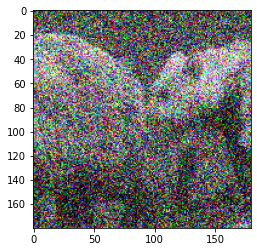

In [ ]:
plt.imshow(image_noisy[0])

#CREATING TRAINING AND VALIDATION DATASET

In [ ]:

train_images = images[0:320]
train_images_noisy = image_noisy[0:320]

val_images = images[321:398]
val_images_noisy = image_noisy[321:398]

print(train_images.shape, train_images_noisy.shape, val_images.shape, val_images_noisy.shape)

(320, 180, 180, 3) (320, 180, 180, 3) (77, 180, 180, 3) (77, 180, 180, 3)


#MODEL ARCHITECTURE

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model


input = layers.Input(shape=(180, 180, 3))

# Encoder
# upper model
x1 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x2 = layers.Conv2D(32, (3, 3), activation="relu", padding="same",dilation_rate=(2,2))(x1)

# lower model
y1 = layers.Conv2D(32, (3, 3), activation="relu", padding="same",dilation_rate=(2,2))(input)
y2 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(y1)

# concat upper and lower model in feature extraction
concatenated = tf.keras.layers.Concatenate(axis=-1)([x1, x2, y1, y2])

# Start of feature integration
conc_conv1 = layers.Conv2D(32, (1, 1), activation="sigmoid", padding="same")(concatenated)

x3 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(conc_conv1)
x4 = layers.Conv2D(32, (3, 3), activation="relu", padding="same",dilation_rate=(2,2))(x3)

# x4  = layers.Dropout(0.2)(x4)

y3 = layers.Conv2D(32, (3, 3), activation="relu", padding="same",dilation_rate=(2,2))(conc_conv1)
y4 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(y3)

# y4  = layers.Dropout(0.2)(y4)

concatenated2 = tf.keras.layers.Concatenate(axis=-1)([x3, x4, y3, y4])




print(concatenated2.shape)

conc_conv2 = layers.Conv2D(32, (1, 1), activation="sigmoid", padding="same")(concatenated2)

concatenated3 = tf.keras.layers.Concatenate(axis=-1)([conc_conv1, conc_conv2])

print(concatenated3.shape)

# reconstruction
x = layers.Conv2DTranspose(32, (3, 3), activation="relu", padding="same")(concatenated3)
x = layers.Conv2DTranspose(32, (3, 3), activation="relu",  padding="same", dilation_rate=(2,2))(x)
out = layers.Conv2D(3, (1, 1), activation="sigmoid", padding="same")(x)

print(out.shape)

# running the model
autoencoder = Model(input, out)
opt = keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=opt, loss="binary_crossentropy", metrics = ['accuracy'])
autoencoder.summary()
train_images = images[0:320]
train_images_noisy = image_noisy[0:320]

val_images = images[321:398]
val_images_noisy = image_noisy[321:398]



(None, 180, 180, 128)
(None, 180, 180, 64)
(None, 180, 180, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 180, 180, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 180, 180, 32  896         ['input_1[0][0]']                
                               

#FITTING DATA

In [ ]:
history = autoencoder.fit(x=train_images_noisy,y=train_images,epochs=40,batch_size=32,validation_data=(val_images_noisy, val_images))

Epoch 1/40
10/10 [==============================] - 19s 545ms/step - loss: 0.6940 - accuracy: 0.5079 - val_loss: 0.6757 - val_accuracy: 0.0301
Epoch 2/40
10/10 [==============================] - 4s 437ms/step - loss: 0.6813 - accuracy: 0.4608 - val_loss: 0.6632 - val_accuracy: 0.6657
Epoch 3/40
10/10 [==============================] - 4s 439ms/step - loss: 0.6588 - accuracy: 0.1158 - val_loss: 0.6153 - val_accuracy: 0.0184
Epoch 4/40
10/10 [==============================] - 4s 442ms/step - loss: 0.6136 - accuracy: 0.2425 - val_loss: 0.5815 - val_accuracy: 0.7034
Epoch 5/40
10/10 [==============================] - 4s 442ms/step - loss: 0.5966 - accuracy: 0.3996 - val_loss: 0.5713 - val_accuracy: 0.0153
Epoch 6/40
10/10 [==============================] - 4s 452ms/step - loss: 0.5911 - accuracy: 0.5219 - val_loss: 0.5673 - val_accuracy: 0.0137
Epoch 7/40
10/10 [==============================] - 4s 447ms/step - loss: 0.5893 - accuracy: 0.3448 - val_loss: 0.5653 - val_accuracy: 0.2174
Epoch

# Sharpen Image

In [ ]:
# class Sharpen(tf.keras.layers.Layer):
#     def __init__(self, num_outputs):
#         super(Sharpen, self).__init__()
#         self.num_outputs = num_outputs

#     def build(self, input_shape):
#         self.kernel = np.array([[0, -0.5, 0], 
#                                 [-0.5, 3, -.5], 
#                                 [0, -0.5, 0]])
#         self.kernel = tf.expand_dims(self.kernel, 0)
#         self.kernel = tf.expand_dims(self.kernel, 0)
#         self.kernel = tf.cast(self.kernel, tf.float32)

#     def call(self, input_):
#         return tf.nn.conv2d(input_, self.kernel, strides=[1, 1, 1, 1], padding='SAME')
# sharpened_layer = Sharpen(num_outputs = (180,180,3))(out)

#CREATING TEST DATASET

<class 'numpy.ndarray'>


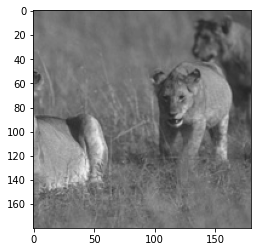

In [ ]:
test_image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/train400/007.png")
input_arr = tf.keras.preprocessing.image.img_to_array(test_image)
# input_arr = np.array([input_arr])  # Convert single image to a batch.
# predictions = model.predict(input_arr)
print(type(input_arr))
# input_arr = input_arr.reshape(3,180,180)
test_image = np.divide(input_arr, 255.0)

plt.imshow(test_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


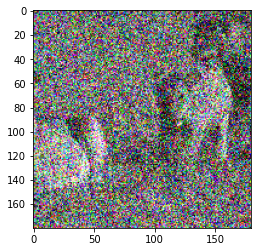

In [ ]:
test_image_noisy = noisy(test_image)
plt.imshow(test_image_noisy)

#PREDICTING MODEL

In [ ]:
reco = autoencoder.predict(test_image_noisy[None])[0]

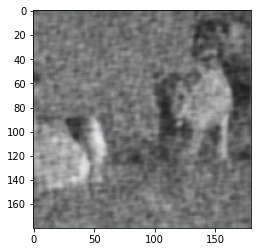

In [ ]:
plt.imshow(reco)

#PLOTTING GRAPH



In [ ]:
def plotting_graph(history,parameter):
  Y = []
  Z = []
  if parameter is "Loss":
    Y = np.array(history.history['loss'])
    Z = np.array(history.history['val_loss'])
  else:
    Y = np.array(history.history['accuracy'])
    Z = np.array(history.history['val_accuracy'])

  plt.plot(Y, color='r', label='training '+parameter)
  plt.plot(Z, color='g', label='validation '+parameter)
  plt.xlabel("Epochs")
  plt.ylabel(parameter)
  plt.title("{} vs Epoch".format(parameter))

  plt.legend()
  plt.show()

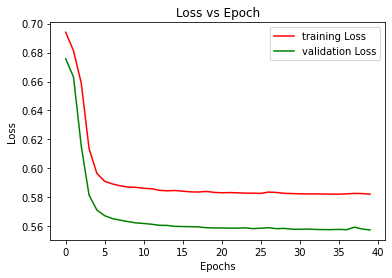

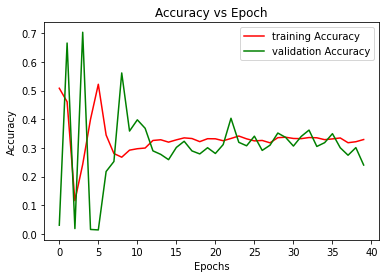

In [ ]:
plotting_graph(history,"Loss")
plotting_graph(history,"Accuracy")